In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import requests

Read raw data from csv file. The file contains data about all german power stations burning fossil fuels.

In [3]:
data = pd.read_csv("power_stations_raw.csv")
# Source:
# https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/Kraftwerksliste/kraftwerksliste-node.html
# https://de.wikipedia.org/wiki/Liste_fossil-thermischer_Kraftwerke_in_Deutschland
print(data)

                                               KW-Name  \
0                     Gasturbinenkraftwerk Ahrensfelde   
1                       Heizkraftwerk Altbach/Deizisau   
2    Industriekraftwerk Amsdorf\n(Grubenheizkraftwerk)   
3                         Industriekraftwerk Annweiler   
4                         Industriekraftwerk Appeldorn   
..                                                 ...   
322                         Industriekraftwerk Zielitz   
323                                  Kraftwerk Zolling   
324                         Industriekraftwerk Zülpich   
325             Industriekraftwerk Zuckerfabrik Anklam   
326                         Industriekraftwerk Zwickau   

                              Brutto­leistung\nin MWel  \
0                                                  152   
1    1350 (davon 855 Steinkohle, 305 Erdgas und 190...   
2                                                   55   
3                                               ca. 30   
4            

Cleaning the data. We only keep the stations name, its power outputs (electrical and thermal), its fuel and the state it is in. We also rename the columns to something more handy.

In [4]:
data = data[[
    'KW-Name', 'Brutto­leistung\nin MWel', 'Wärmeaus­kopplung\nin MWth',
    'Energie­träger', 'Bun­des­land'
]]
print(data)
data = data.rename(columns={
    'KW-Name': 'name',
    'Brutto­leistung\nin MWel': 'electrical_power',
    'Wärmeaus­kopplung\nin MWth': 'thermal_power',
    'Energie­träger': 'fuel',
    'Bun­des­land': 'state'
})
data['state'] = data['state'].apply(
    lambda s: s.split(" ")[0].strip()
)
print(data)

                                               KW-Name  \
0                     Gasturbinenkraftwerk Ahrensfelde   
1                       Heizkraftwerk Altbach/Deizisau   
2    Industriekraftwerk Amsdorf\n(Grubenheizkraftwerk)   
3                         Industriekraftwerk Annweiler   
4                         Industriekraftwerk Appeldorn   
..                                                 ...   
322                         Industriekraftwerk Zielitz   
323                                  Kraftwerk Zolling   
324                         Industriekraftwerk Zülpich   
325             Industriekraftwerk Zuckerfabrik Anklam   
326                         Industriekraftwerk Zwickau   

                              Brutto­leistung\nin MWel  \
0                                                  152   
1    1350 (davon 855 Steinkohle, 305 Erdgas und 190...   
2                                                   55   
3                                               ca. 30   
4            

Dropping all rows with no "Braunkohle".

In [5]:
data = data[data['fuel'].str.contains('Braunkohle')]

Dropping all columns with states that are not served by "50Hertz GmbH". The Bundesnetzagentur delivers data specifically for the 50Hertz grid which also covers the Lausitz region.

In [6]:
states_to_drop = [
    "Nordrhein-Westfalen",
    "Niedersachsen",
    "Hessen",
    "Bayern",
]
for state in states_to_drop:
    data = data[data['state'].str.contains(state)==False]
print(data)

                                                  name  \
2    Industriekraftwerk Amsdorf\n(Grubenheizkraftwerk)   
44                                   Kraftwerk Boxberg   
61                         Heizkraftwerk Chemnitz-Nord   
63                               Heizkraftwerk Cottbus   
68                           Industriekraftwerk Deuben   
103                     Heizkraftwerk Frankfurt (Oder)   
129                       Industriekraftwerk Hainsberg   
164                              Kraftwerk Jänschwalde   
184                              Heizkraftwerk Könnern   
204                               Kraftwerk Lippendorf   
225                          Heizkraftwerk Neugersdorf   
264                                 Kraftwerk Schkopau   
265                       Industriekraftwerk Schönfeld   
270                           Kraftwerk Schwarze Pumpe   
297                                  Kraftwerk Wählitz   
321                                    Kraftwerk Zeitz   

             

Clean power values and convert them to number format.

In [7]:
def cleanup_power_column(value: str) -> int:
    value = value.split("\n")[0].split(" ")[0].strip()
    try:
        value = int(value)
    except ValueError:
        return np.nan
    else:
        return value
    
data['electrical_power'] = data['electrical_power'].apply(cleanup_power_column)
data['thermal_power'] = data['thermal_power'].apply(cleanup_power_column)

Some power stations don't burn only "Braunkohle". These corrections compensate for this.

In [8]:
corrections = [
    {
        'name': "Heizkraftwerk Chemnitz-Nord",
        'electrical_power': 165 + 140
        # https://de.wikipedia.org/wiki/Heizkraftwerk_Chemnitz-Nord#Zahlen_zum_Heizkraftwerk
    },
    {
        'name': "Kraftwerk Lippendorf",
        'electrical_power': 1850 * 0.975
        # https://de.wikipedia.org/wiki/Kraftwerk_Lippendorf#Technische_Beschreibung
    },
    {
        'name': "Kraftwerk Zeitz",
        'electrical_power': 45  # see raw data
    },
    {
        'name': "Heizkraftwerk Frankfurt (Oder)",
        'electrical_power': 24  # see raw data
    }
]

for correction in corrections:
    name = correction['name']
    power = correction['electrical_power']
    old_power = data.loc[data.name == name, 'electrical_power'].values[0]
    thermal_power = data.loc[data.name == name, 'thermal_power'].values[0]
    
    data.loc[data.name == name, 'electrical_power'] = power
    data.loc[data.name == name, 'thermal_power'] = thermal_power * (float(power) / float(old_power))

print(data)

                                                  name  electrical_power  \
2    Industriekraftwerk Amsdorf\n(Grubenheizkraftwerk)             55.00   
44                                   Kraftwerk Boxberg           2582.00   
61                         Heizkraftwerk Chemnitz-Nord            305.00   
63                               Heizkraftwerk Cottbus             82.00   
68                           Industriekraftwerk Deuben             86.00   
103                     Heizkraftwerk Frankfurt (Oder)             24.00   
129                       Industriekraftwerk Hainsberg              1.00   
164                              Kraftwerk Jänschwalde           3000.00   
184                              Heizkraftwerk Könnern             29.00   
204                               Kraftwerk Lippendorf           1803.75   
225                          Heizkraftwerk Neugersdorf              2.00   
264                                 Kraftwerk Schkopau            980.00   
265         

Create a linear model to map between electrical power and thermal power to fill missing values for thermal power. (Yes it is not the best fit but for an educated guess it is fine I think.)

                                                  name  electrical_power  \
2    Industriekraftwerk Amsdorf\n(Grubenheizkraftwerk)             55.00   
44                                   Kraftwerk Boxberg           2582.00   
61                         Heizkraftwerk Chemnitz-Nord            305.00   
63                               Heizkraftwerk Cottbus             82.00   
68                           Industriekraftwerk Deuben             86.00   
103                     Heizkraftwerk Frankfurt (Oder)             24.00   
129                       Industriekraftwerk Hainsberg              1.00   
164                              Kraftwerk Jänschwalde           3000.00   
184                              Heizkraftwerk Könnern             29.00   
204                               Kraftwerk Lippendorf           1803.75   
225                          Heizkraftwerk Neugersdorf              2.00   
264                                 Kraftwerk Schkopau            980.00   
270         

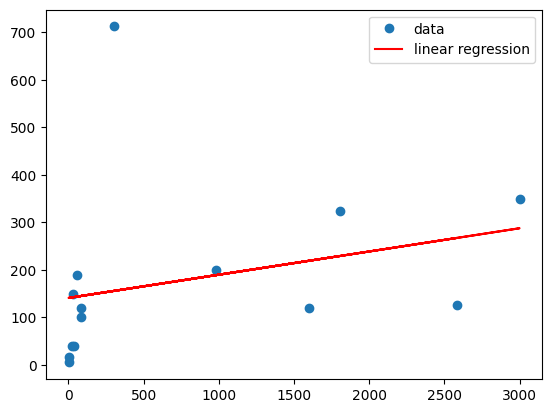

                                                  name  electrical_power  \
2    Industriekraftwerk Amsdorf\n(Grubenheizkraftwerk)             55.00   
44                                   Kraftwerk Boxberg           2582.00   
61                         Heizkraftwerk Chemnitz-Nord            305.00   
63                               Heizkraftwerk Cottbus             82.00   
68                           Industriekraftwerk Deuben             86.00   
103                     Heizkraftwerk Frankfurt (Oder)             24.00   
129                       Industriekraftwerk Hainsberg              1.00   
164                              Kraftwerk Jänschwalde           3000.00   
184                              Heizkraftwerk Könnern             29.00   
204                               Kraftwerk Lippendorf           1803.75   
225                          Heizkraftwerk Neugersdorf              2.00   
264                                 Kraftwerk Schkopau            980.00   
265         

In [9]:
data_wo_nan = data.dropna()
print(data_wo_nan)
model = sp.stats.linregress(data_wo_nan['electrical_power'], data_wo_nan['thermal_power'])
plt.plot(data_wo_nan['electrical_power'], data_wo_nan['thermal_power'], 'o')
plt.plot(data_wo_nan['electrical_power'], model.intercept + model.slope * data_wo_nan['electrical_power'], 'r')
plt.legend(['data', 'linear regression'])
plt.show()

def guess_thermal_power(power: int, thermal_power: int) -> int:
    if thermal_power == np.nan:
        return model.intercept + model.slope * power
    else:
        return thermal_power

data['thermal_power'] = data.apply(lambda d: guess_thermal_power(d['electrical_power'], d["thermal_power"]), axis=1)
print(data)

Compute the total power production (electrical and thermal) of the "Braunkohle" power stations.

In [10]:
total_electrical_power_production = data['electrical_power'].sum()
total_thermal_power_production = data['thermal_power'].sum()
print(total_electrical_power_production)
print(total_thermal_power_production)

10632.75
2489.957763875532


Filter for all power stations that are connected to the LEAG train network and also add their efficiencies.

In [11]:
lausitz_power_plants = [
    "Kraftwerk Boxberg",
    "Kraftwerk Jänschwalde",
    "Kraftwerk Schwarze Pumpe"
]
efficiencies = [
    0.42,  # https://de.wikipedia.org/wiki/Kraftwerk_Boxberg#Aufbau_und_technische_Daten
    0.355,  # https://de.wikipedia.org/wiki/Kraftwerk_J%C3%A4nschwaldeAufbau_und_Technische_Daten
    0.4,  # https://de.wikipedia.org/wiki/Kraftwerk_Schwarze_Pumpe#Technische_Daten
]

data = data[data['name'].isin(lausitz_power_plants)]
data['efficiency'] = efficiencies
data = data.drop(columns=['fuel', 'state'], axis=0)
print(data)

                         name  electrical_power  thermal_power  efficiency
44          Kraftwerk Boxberg            2582.0          125.0       0.420
164     Kraftwerk Jänschwalde            3000.0          349.0       0.355
270  Kraftwerk Schwarze Pumpe            1600.0          120.0       0.400


Compute the coal consumption of a power station given the "Braunkohle" based electrical power production in the whole 50Hertz grid and the duration in hours.

In [12]:
coal_energy_content = 2.5  # MWh/t
# source: https://enertrag.org/kwh/braunkohle/

def compute_coal_consumption(produced_electrical_power: float, hours: float, station_name: str) -> float:
    station_data = data[data.name.str.contains(station_name)]
    
    # efficiency of the stations power conversion from burning coal to production of electricity and heat
    efficiency = station_data['efficiency'].values[0]
    # the maximum electrical power the station can output
    electrical_power = station_data['electrical_power'].values[0]
    # the maximum thermal power the station can output
    thermal_power = station_data['electrical_power'].values[0]
    
    # the share of the stations electrical power to the overall electrical power in the 50Hertz grid
    electrical_power_share = electrical_power / total_electrical_power_production
    # the ratio between max thermal and max electrical power
    thermal_power_ratio = thermal_power / electrical_power
    
    # the electrical power the station produces given the overall grid production in the given time
    electrical_production = (produced_electrical_power / hours) * electrical_power_share
    # the stations thermal power production
    thermal_production = thermal_power_ratio / electrical_production
    # the stations total power production
    total_production = electrical_production + thermal_production
    
    # the mass of coal in tons the station has to burn in the given time
    coal_mass = hours * total_production / (coal_energy_content * efficiency)
    
    return coal_mass  # in tons
    
print(compute_coal_consumption(6000, 1, "Boxberg"))
print(compute_coal_consumption(6000, 1, "Jänschwalde"))
print(compute_coal_consumption(6000, 1, "Schwarze Pumpe"))

1387.6271580202263
1907.4742863195033
902.871954724912


Compute train amount based on coal mass.

In [13]:
coal_per_waggon = 73 - 40  # t
waggons_per_train = 16
# https://youtu.be/sJYPPdm-HdE?t=39

coal_per_train = coal_per_waggon * waggons_per_train

def train_amount(coal_mass: float) -> int:
    return round(coal_mass / coal_per_train)

for name in ["Boxberg", "Jänschwalde", "Schwarze Pumpe"]:
    # 6000 MWh in 1 hour from "Braunkohle" in the entire 50Hertz grid.
    coal_mass = compute_coal_consumption(6000, 1, name)
    trains = train_amount(coal_mass)
    print(f"{name}: {trains} trains")

Boxberg: 3 trains
Jänschwalde: 4 trains
Schwarze Pumpe: 2 trains


In [18]:
resolution = 'quarterhour'
braunkohle_code = '1223'
region = '50Hertz'
# timestamp = '1680300000'  # 2023-04-01-00-00-00
url = f"https://www.smard.de/app/chart_data/{braunkohle_code}/{region}/index_{resolution}.json"

response = requests.get(url)
timestamp = response.json()['timestamps'][0]
print(timestamp)

url = f"https://www.smard.de/app/chart_data/{braunkohle_code}/{region}/{braunkohle_code}_{region}_{resolution}_{timestamp}.json"
response = requests.get(url)
print(response.json())

1419807600000
{'meta_data': {'version': 1, 'created': 1669821574965}, 'series': [[1419807600000, None], [1419808500000, None], [1419809400000, None], [1419810300000, None], [1419811200000, None], [1419812100000, None], [1419813000000, None], [1419813900000, None], [1419814800000, None], [1419815700000, None], [1419816600000, None], [1419817500000, None], [1419818400000, None], [1419819300000, None], [1419820200000, None], [1419821100000, None], [1419822000000, None], [1419822900000, None], [1419823800000, None], [1419824700000, None], [1419825600000, None], [1419826500000, None], [1419827400000, None], [1419828300000, None], [1419829200000, None], [1419830100000, None], [1419831000000, None], [1419831900000, None], [1419832800000, None], [1419833700000, None], [1419834600000, None], [1419835500000, None], [1419836400000, None], [1419837300000, None], [1419838200000, None], [1419839100000, None], [1419840000000, None], [1419840900000, None], [1419841800000, None], [1419842700000, None],